# Estimating Treatment Effect Using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lifelines.utils import concordance_index

In [2]:
np.set_printoptions(suppress=True)
plt.style.use("bmh")
config = {'figure.figsize': (16, 3),
          'axes.titlesize': 18,
          'axes.labelsize': 10,
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

In this work, the effects of the combination of Levamisole and Fluorouracil on patients who had colon cancer surgery will be analyzed by examining data from an RCT.

# Randomized controlled trial

In the design of experiments, there are two groups that can be discerned. Treatments are applied to experimental units in a **treatment or experimental group**, while the **control group** receives either a standard treatment, a placebo, or no treatment at all.

A randomized controlled trial (RCT) is a type of scientific experiment of intervention study that aims to reduce certain sources of bias when testing the effectiveness of new treatments by randomly allocating subjects to two or more groups, treating them differently, and then comparing them with respect to a measured response. The treatment group receives the intervention being assessed, while the control group receives an alternative treatment or no treatment. The groups are monitored under conditions of the trial design to determine the effectiveness of the experimental intervention, and efficacy is assessed in comparison to the control.

# Data set

* sex (binary): 1 if Male, 0 otherwise
* age (int): age of patient at start of the study
* obstruct (binary): obstruction of colon by tumor
* perfor (binary): perforation of colon
* adhere (binary): adherence to nearby organs
* nodes (int): number of lymphnodes with detectable cancer
* node4 (binary): more than 4 positive lymph nodes
* outcome (binary): 1 if died within 5 years
* TRTMT (binary): treated with levamisole + fluoroucil
* differ (one-hot): differentiation of tumor
* extent (one-hot): extent of local spread

In [3]:
data = pd.read_csv("levamisole_data.csv", index_col=0)

# Data Analysis

In [4]:
print(f'Data Shape: {data.shape}')
data.head()

Data Shape: (607, 14)


,sex,age,obstruct,perfor,adhere,nodes,node4,outcome,TRTMT,differ_2.0,differ_3.0,extent_2,extent_3,extent_4
1,1,43,0,0,0,5.0,1,1,True,1,0,0,1,0
2,1,63,0,0,0,1.0,0,0,True,1,0,0,1,0
3,0,71,0,0,1,7.0,1,1,False,1,0,1,0,0
4,0,66,1,0,0,6.0,1,1,True,1,0,0,1,0
5,1,69,0,0,0,22.0,1,1,False,1,0,0,1,0


In [5]:
proportion_treated = np.mean(data['TRTMT'] == 1)

print(f'Proportion Treated: {proportion_treated:.2%}')

Proportion Treated: 49.09%


In [6]:
treated_prob = np.sum((data['TRTMT'] == 1) & (data['outcome'] == 1)) / np.sum((data['TRTMT'] == 1))
control_prob = np.sum((data['TRTMT'] == 0) & (data['outcome'] == 1)) / np.sum((data['TRTMT'] == 0))

print(f'Death rate (proportion) for treated patients: {treated_prob:.2}')
print(f'Death rate (proportion) for untreated patients: {control_prob:.2}')

Death rate (proportion) for treated patients: 0.37
Death rate (proportion) for untreated patients: 0.48


It's important to compute these basic summary statistics as a sanity check for more complex models later on. If they strongly disagree with these robust summaries and there isn't a good reason, then there might be a bug. On average, it seemed like treatment had a positive effect. 

# Data Pre-processing

In [7]:
X = data.drop('outcome', axis=1)
y = data['outcome'] 

In [8]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Modeling Treatment Effect

First, the treatment effect will be modeled using a logistic regression.

In [9]:
lr = LogisticRegression(max_iter=10000).fit(X_dev, y_dev)

In [10]:
treatment_coefficient = lr.coef_[0][np.flatnonzero(data.columns == 'TRTMT')[0]]

treatment_odds_ratio = np.exp(treatment_coefficient)

print(f'Theta_TRTMT: {treatment_coefficient:.4f}')
print(f'Treatment Odds Ratio: {treatment_odds_ratio:.4f}')

Theta_TRTMT: -0.1780
Treatment Odds Ratio: 0.8369


The treatment coefficient is a negative value, meaning that it has the effect of reducing risk of death. Based on this model, it seems that the treatment has a beneficial effect. It can be interpreted that the treatment reduces the odds of death by $(1 - OddsRatio) = 0.16$.

## Absolute Risk Reduction

The risk difference, excess risk, or attributable risk is the difference between the risk of an outcome in the exposed group (treatment group) and the unexposed group (control group). It is computed as

$I_e - I_u$

where $I_e$ and $I_u$ are the incidence in the exposed group and in the unexposed group, respectively.

The absolute risk reduction (ARR) of a treatment is defined as 

$$ARR = I_u - I_e$$

or

$$ARR = p_{baseline} - p_{treatment}$$

where $p$ is the baseline probability of death and $p_{treatment}$ is the probability of death if treated.

The **number needed to treat** is an epidemiological measure used in communicating the effectiveness of a health-care intervention, typically a treatment with medication. The NNT is the average number of patients who need to be treated to prevent one additional bad outcome. If, for example, there is an ARR of 0.2, on average, then $1/0.2 = 5$ people need to receive the treatment in order to benefit one of them.

In [11]:
def OR_to_ARR(p, odds_ratio):

    # compute baseline odds from p
    odds_baseline = p/(1-p)

    # compute odds of treatment using odds ratio
    odds_trtmt = odds_ratio*odds_baseline

    # compute new probability of death from treatment odds
    p_trtmt = odds_trtmt/(1+odds_trtmt)

    # compute ARR using treated probability and baseline probability 
    ARR = p - p_trtmt
    
    return ARR

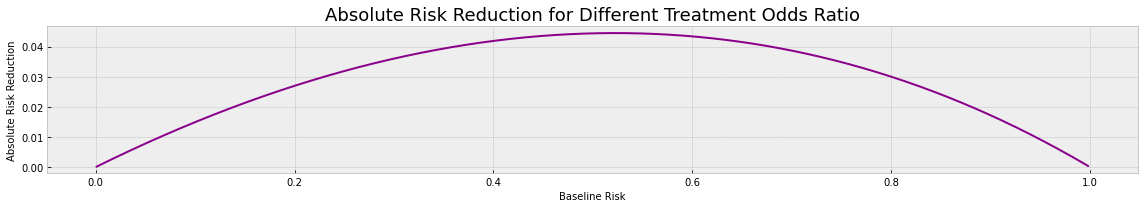

In [12]:
ps = np.arange(0.001, 0.999, 0.001)
diffs = [OR_to_ARR(p, treatment_odds_ratio) for p in ps]
plt.plot(ps, diffs)
plt.title("Absolute Risk Reduction for Different Treatment Odds Ratio")
plt.xlabel('Baseline Risk')
plt.ylabel('Absolute Risk Reduction')
plt.tight_layout()
plt.show()

It is sought to evaluate how closely the empirical (actual) risk reduction matches the risk reduction that is predicted by the logistic regression model. This is complicated by the fact that for each patient, only one outcome (treatment or no treatment) is observed, and the alternative scenario can never be performed. Therefore, patients will be grouped based on their baseline risk as predicted by the model, and then plot their empirical ARR within groups that have similar baseline risks. 

The baseline risk is the model's predicted probability that the patient is predicted to die if they do not receive treatment. The empirical ARR is the death rate of the untreated patients in that group minus the death rate of the treated patients in that group.

$$ARR_{\text{empirical}} = p_{\text{baseline}} - p_{\text{treatment}}$$

The prediction of the baseline risk will be given by the logistic regression model.

In [13]:
X_no_treatment = X_dev.copy()
X_no_treatment['TRTMT'] = False
baseline_risk = lr.predict_proba(X_no_treatment)[:,1]

risk_groups = pd.cut(baseline_risk, 10)

data_risks = X_dev.copy()
data_risks['baseline_risk'] = baseline_risk
data_risks['risk_group'] = risk_groups
data_risks['y'] = y_dev

baseline_mean_by_risk_group = data_risks[data_risks['TRTMT'] == False].groupby('risk_group')['y'].mean()
treatment_mean_by_risk_group = data_risks[data_risks['TRTMT'] == True].groupby('risk_group')['y'].mean()

abs_risks = baseline_mean_by_risk_group - treatment_mean_by_risk_group
abs_risks.index = data_risks.groupby('risk_group')['baseline_risk'].mean()
abs_risks.name = 'ARR'

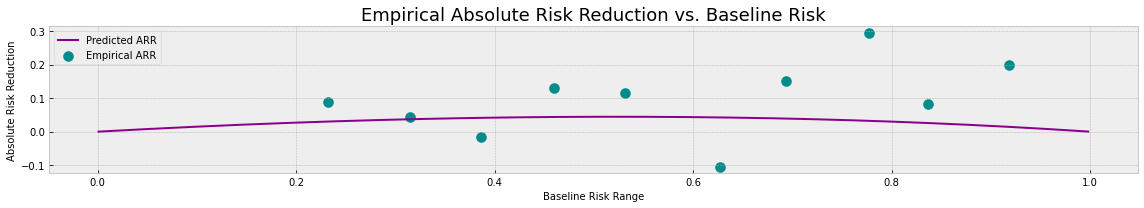

In [14]:
plt.scatter(abs_risks.index, abs_risks, label='Empirical ARR', color='darkcyan')
plt.plot(ps, diffs, label='Predicted ARR')

plt.title("Empirical Absolute Risk Reduction vs. Baseline Risk")
plt.ylabel("Absolute Risk Reduction")
plt.xlabel("Baseline Risk Range")

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The empirical absolute risk reduction does not match the predicted risk reduction from the logistic regression model, indicating that ARR may depend on more than simply the baseline risk, as if ARR depended only on baseline risk, the dots would be near the line in most cases.

# Evaluation Metric: C-statistic-for-benefit

An estimation of the regular Concordance index will be used to evaluate the discriminative power the models for predicting ARR:

$$P(A \text{ has higher predicted ARR than } B| A \text{ experienced a greater risk reduction than } B)$$

However, the fundamental problem is that for each person, either their treatment outcome or their baseline outcome can be observed, not both, as the patient either receives the treatment, or does not receive the treatment, meaning that their actual risk reduction cannot be calculated. 

Instead, people will be matched across treatment and control arms based on predicted ARR. In each pair, both outcomes will be observed, so an estimate of the true treatment effect can be made. The patients pair can be thought as a substitute for the the ideal data that has the same exact patient in both the treatment and control group.

$$P(P_1\text{ has a predicted ARR greater than }P_2 | P_1\text{ experiences greater risk reduction than }P_2)$$

where $P_1$ is a pair of two patients where A receives treatment and B does not, and $P_2$ is another pair of two patients where A receives treatment and B does not.

The risk reduction for each pair is:
- 1 if the treated person A survives and the untreated B person does not (treatment helps).  
- -1 if the treated person A dies and the untreated person B doesn't (treatment harms)
- 0 otherwise (treatment has no effect, because both patients in the pair live, or both die).

Finally, the C-for-benefit given the matched pairs is calculated as:

$$\text{c for benefit score} = \frac{\text{concordant} + 0.5 \times \text{risk ties}}{\text{permissible}}$$

* A permissible pair of pairs happens when the observed benefit is different between the two pairs of pairs of patients. 
* A concordant pair happens if the observed benefit and predicted benefit of pair 1 are both less than those for pair 2; or, the observed and predicted benefit of pair 1 are both greater than those for pair 2, and the pair of pairs are permissible. 
* A risk tie occurs if the predicted benefits of both pairs are equal, and it's also a permissible pair of pairs.

In [15]:
def c_for_benefit_score(pairs):
    
    # mapping pair outcomes to benefit
    obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }
    
    # compute observed benefit for each pair
    obs_benefit = [obs_benefit_dict[(i[1],j[1])] for (i,j) in pairs]

    # compute average predicted benefit for each pair
    pred_benefit = [np.mean([i[0],j[0]]) for (i,j) in pairs]

    concordant_count, permissible_count, risk_tie_count = 0, 0, 0

    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            
            # if the observed benefit is different, increment permissible count
            if obs_benefit[i] != obs_benefit[j]:

                # increment count of permissible pairs
                permissible_count = permissible_count + 1
                
                # if concordant, increment count
                concordance = ((pred_benefit[i]>pred_benefit[j] and obs_benefit[i]>obs_benefit[j]) or (pred_benefit[i]<pred_benefit[j] and obs_benefit[i]<obs_benefit[j]))
                
                if (concordance): # change to check for concordance
                    
                    concordant_count = concordant_count + 1

                # if risk tie, increment count
                if (pred_benefit[i]==pred_benefit[j]): #change to check for risk ties
                    risk_tie_count = risk_tie_count + 1


    cstat = (concordant_count + (0.5 * risk_tie_count)) / permissible_count
    
    return cstat

In [16]:
def c_statistic(pred_risk_reduction, true_outcomes, true_treatments, random_seed=0):
    
    assert len(pred_risk_reduction) == len(true_treatments) == len(true_outcomes)
    random.seed(random_seed)
    
    # Collect pred_risk_reduction, y, and w into tuples for each patient
    tuples = list(zip(pred_risk_reduction,true_outcomes,true_treatments))
    
    # Collect untreated patient tuples, stored as a list
    untreated = list(filter(lambda x:x[2]==True, tuples))
    
    # Collect treated patient tuples, stored as a list
    treated = list(filter(lambda x:x[2]==False, tuples))

    # randomly subsample to ensure every person is matched
    
    # if there are more untreated than treated patients, randomly choose a subset of untreated patients, one for each treated patient.

    if len(treated) < len(untreated):
        untreated = random.sample(untreated,k=len(treated))
        
    # if there are more treated than untreated patients, randomly choose a subset of treated patients, one for each treated patient.
    if len(untreated) < len(treated):
        treated = random.sample(treated,k=len(untreated))
        
    assert len(untreated) == len(treated)

    # Sort the untreated patients by their predicted risk reduction
    untreated = sorted(untreated,key=lambda x:x[0])
    
    # Sort the treated patients by their predicted risk reduction
    treated = sorted(treated,key=lambda x:x[0])
    
    # match untreated and treated patients to create pairs together
    pairs = list(zip(treated,untreated))

    # calculate the c-for-benefit using these pairs (use the function that you implemented earlier)
    cstat = c_for_benefit_score(pairs)
    
    return cstat

In order to compute the c-statistic-for-benefit, the predicted risk reduction from treatment must be computed.

In [17]:
X_test_treated = X_test.copy(deep=True)
X_test_untreated = X_test.copy(deep=True)
X_test_treated.loc[:, 'TRTMT'] = 1
X_test_untreated.loc[:, 'TRTMT'] = 0

treatment_risk = lr.predict_proba(X_test_treated)[:, 1]
control_risk = lr.predict_proba(X_test_untreated)[:, 1]
risk_reduction_lr = control_risk - treatment_risk

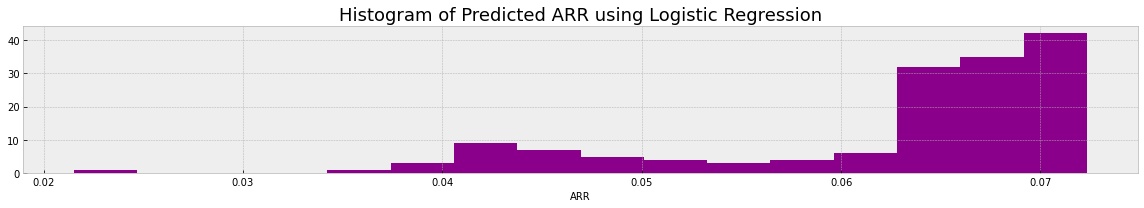

In [51]:
plt.hist(risk_reduction_lr, bins='auto')
plt.title("Histogram of Predicted ARR using Logistic Regression")
plt.xlabel("ARR")
plt.tight_layout()
plt.show()

Although different absolute risk reduction are predicted, the model never predicts that the treatment will adversely impact risk. This is because the odds ratio of treatment is less than 1, so the model always predicts a decrease in the baseline risk.

In [19]:
cstat_test = c_statistic(risk_reduction_lr, y_test, X_test['TRTMT'])
print(f"C-for-Benefit for Logistic Regression: {cstat_test:.4f}")

C-for-Benefit for Logistic Regression: 0.5412


### Regular c-index

The regular c-index is evaluating the model's ability to predict overall patient risk, not necessarily measuring how well the model predicts benefit from treatment.

In [20]:
regular_cindex = concordance_index(y_test, lr.predict_proba(X_test)[:, 1])
print(f"Regular C-index for Logistic Regression: {regular_cindex:.4f}")

Regular C-index for Logistic Regression: 0.7783


Even though the model accurately predicts overall risk (regular c-index), it does not necessarily do a great job predicting benefit from treatment (c-for-benefit).

In [21]:
def quantile_benefit(X, y, arr_hat):
    df = X.copy(deep=True)
    df.loc[:, 'y'] = y
    df.loc[:, 'benefit'] = arr_hat
    benefit_groups = pd.qcut(arr_hat, 10)
    df.loc[:, 'benefit_groups'] = benefit_groups
    empirical_benefit = df.loc[df.TRTMT == 0, :].groupby('benefit_groups').y.mean() - df.loc[df.TRTMT == 1].groupby('benefit_groups').y.mean()
    avg_benefit = df.loc[df.TRTMT == 0, :].y.mean() - df.loc[df.TRTMT==1, :].y.mean()
    return empirical_benefit, avg_benefit

def plot_empirical_risk_reduction(emp_benefit, av_benefit, model):
    
    plt.scatter(np.arange(len(emp_benefit)), emp_benefit)
    plt.hlines(av_benefit, 0, 9, linestyle='--', label='average RR')
    
    plt.xticks(np.arange(len(emp_benefit)), np.arange(1, len(emp_benefit) + 1))
    
    plt.title(f'Empirical Risk Reduction vs. Predicted {model}')
    plt.ylabel('Empirical Risk Reduction')
    plt.xlabel('Predicted Risk Reduction Quantile')
    plt.legend()
    plt.tight_layout()
    plt.show()

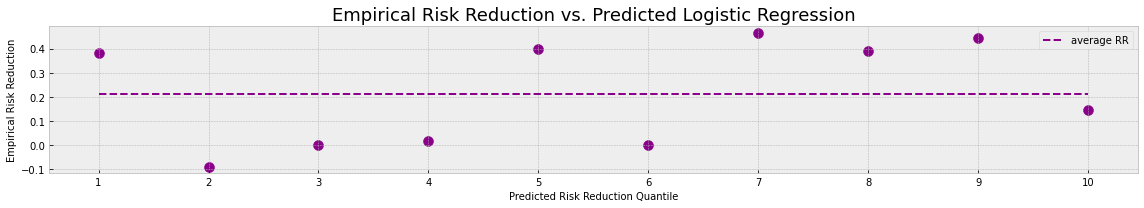

In [22]:
emp_benefit, avg_benefit = quantile_benefit(X_test, y_test, risk_reduction_lr)
plot_empirical_risk_reduction(emp_benefit, avg_benefit, "Logistic Regression")

If the model performed well, then then the patients in the higher deciles of predicted risk reduction would also have higher empirical risk reduction.

# T-Learner

[T-learner](https://arxiv.org/pdf/1706.03461.pdf) is an algorithm developed in 2019 to estimate the conditional average treatment effect (CATE) function.

The T-learner learns two different models, one for treatment risk, and another model for control risk, and then it takes the difference of the two risk predictions to predict the risk reduction.

In [23]:
def T_Learner(treatment_estimator, control_estimator, X):

    # predict the risk of death using the control estimator
    risk_control = control_estimator.predict_proba(X)[:,1]

    # predict the risk of death using the treatment estimator
    risk_treatment = treatment_estimator.predict_proba(X)[:,1]

    # the predicted risk reduction is control risk minus the treatment risk
    pred_risk_reduction = risk_control - risk_treatment
    
    return pred_risk_reduction

The dev set will be into a train and validation set, and each of the train and validation sets will be split into *treatment* and *control* groups to train the treatment and control base learners of the T-Learner.

In [24]:
def treatment_dataset_split(X_train, y_train, X_val, y_val):
    
    # From the training set, get features of patients who received treatment
    X_treat_train = X_train[X_train.TRTMT==True]
    
    # drop the 'TRTMT' column
    X_treat_train = X_treat_train.drop(columns='TRTMT')
    
    # From the training set, get the labels of patients who received treatment
    y_treat_train = y_train[X_train.TRTMT==1]

    # From the validation set, get the features of patients who received treatment
    X_treat_val = X_val[X_val.TRTMT==True]
                        
    # Drop the 'TRTMT' column
    X_treat_val = X_treat_val.drop(columns='TRTMT')
                        
    # From the validation set, get the labels of patients who received treatment
    y_treat_val = y_val[X_val.TRTMT==1]
                        
# --------------------------------------------------------------------------------------------
                        
    # From the training set, get the features of patients who did not received treatment
    X_control_train = X_train[X_train.TRTMT==False]
                        
    # Drop the TRTMT column
    X_control_train = X_control_train.drop(columns='TRTMT')
                        
    # From the training set, get the labels of patients who did not receive treatment
    y_control_train = y_train[X_train.TRTMT==False]
    
    # From the validation set, get the features of patients who did not receive treatment
    X_control_val = X_val[X_val.TRTMT==False]
    
    # drop the 'TRTMT' column
    X_control_val = X_control_val.drop(columns='TRTMT')

    # From the validation set, get teh labels of patients who did not receive treatment
    y_control_val = y_val[X_val.TRTMT==False]
    
    return (X_treat_train, y_treat_train,
            X_treat_val, y_treat_val,
            X_control_train, y_control_train,
            X_control_val, y_control_val)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25, random_state = 0)

In [26]:
(X_treat_train, y_treat_train, 
 X_treat_val, y_treat_val,
 X_control_train, y_control_train,
 X_control_val, y_control_val) = treatment_dataset_split(X_train, y_train, X_val, y_val)

The optimal hyperparameters were found by tuning with grid search.

In [27]:
treatment_model = RandomForestClassifier(max_depth=2, random_state=0).fit(X_treat_train, y_treat_train)
best_hyperparam_treat = {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 1, 'random_state': 0}

In [28]:
control_model = RandomForestClassifier(max_depth=2, min_samples_leaf=0.1, random_state=0).fit(X_control_train, y_control_train)
best_hyperparam_ctrl = {'n_estimators': 100, 'max_depth': 2, 'min_samples_leaf': 0.1, 'random_state': 0}

### Validation set

Predict each patient's risk reduction

In [33]:
risk_reduction_validation = T_Learner(treatment_model, control_model, X_val.drop(['TRTMT'], axis=1))

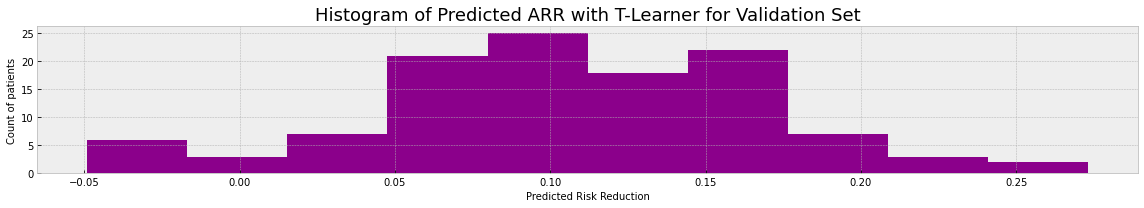

In [35]:
plt.hist(risk_reduction_validation, bins='auto')
plt.title("Histogram of Predicted ARR with T-Learner for Validation Set")
plt.xlabel('Predicted Risk Reduction')
plt.ylabel('Count of patients')
plt.tight_layout()
plt.show()

The T-learner is more flexible compared to the logistic regression model, which only predicts non-negative risk reduction for all patients. As can be seen, risk reduction can be negative, meaning that for some patients the T-learner predicts that treatment will actually increase their risk (negative risk reduction).

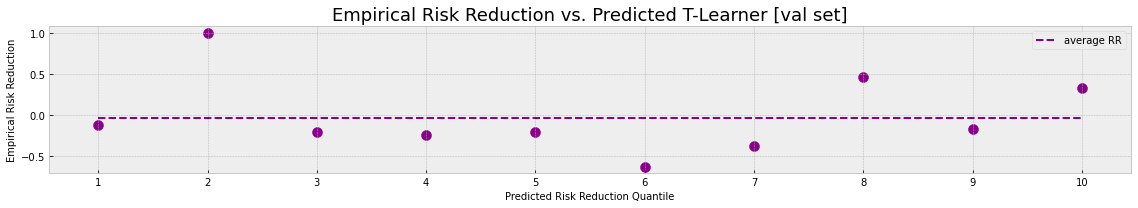

In [38]:
empirical_benefit, avg_benefit = quantile_benefit(X_val, y_val, risk_reduction_validation)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T-Learner [val set]')

A good model would predict a lower risk reduction for patients with actual lower risk reduction. Similarly, a good model would predict a higher risk reduction for patients with actual higher risk reduction. The T-learner seems to be doing a bit better (compared to the logistic regression model) at differentiating between the people who would benefit most treatment and the people who would benefit least from treatment.

In [39]:
c_for_benefit_tlearner_val_set = c_statistic(rr_t_val, y_val, X_val.TRTMT)
print(f"C-for-benefit statistic of T-learner on val set: {c_for_benefit_tlearner_val_set:.4f}")

C-for-benefit statistic of T-learner on val set: 0.5043


### Test set

Predict each patient's risk reduction

In [47]:
risk_reduction_test = T_Learner(treatment_model, control_model, X_test.drop(['TRTMT'], axis=1))

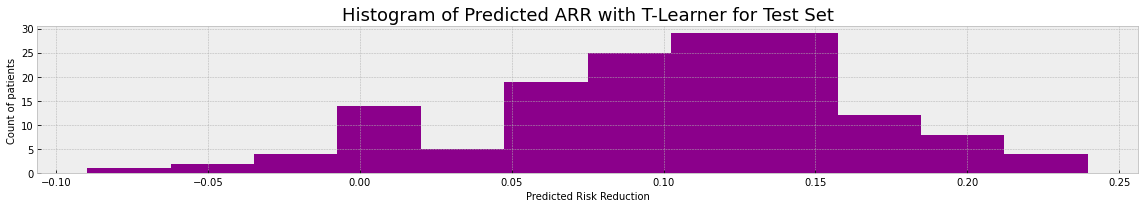

In [49]:
plt.hist(risk_reduction_test, bins='auto')
plt.title("Histogram of Predicted ARR with T-Learner for Test Set")
plt.xlabel('Predicted Risk Reduction')
plt.ylabel('Count of patients')
plt.tight_layout()
plt.show()

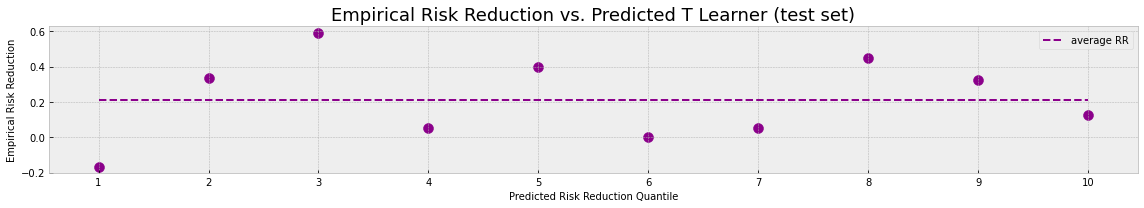

In [45]:
# Plot the predicted versus empirical risk reduction for the test set
empirical_benefit, avg_benefit = quantile_benefit(X_test, y_test, risk_reduction_test)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner (test set)')

In [50]:
c_for_benefit_tlearner_test_set = c_statistic(rr_t_test, y_test, X_test.TRTMT)
print(f"C-for-benefit statistic on test set: {c_for_benefit_tlearner_test_set:.4f}")

C-for-benefit statistic on test set: 0.5250


The c-for-benefit of the two models were evaluated on different test sets. However, their c-for-benefit scores can be compared to get a sense of how they perform:
- logistic regression: 0.5412
- T-learner: 0.5250

The T-learner doesn't actually do better than the logistic regression in this case, but it must be considered that, the sample size is too small to be certain, and models like the T-learner could still be helpful in identifying subgroups who will likely not be helped by treatment, or could even be harmed by treatment, so doctors can study these patients in more detail to find out how to improve their outcomes. 

# References

[Coursera - AI for Medical Treatment](https://www.coursera.org/learn/ai-for-medical-treatment)